<font style="font-size: 32px; color: rgb(2,71,254);">Ornstein-Uhlenbeck Calibration and Simulation.</font><br>

<font style="font-size: 29px"><a href="https://www.researchgate.net/publication/326883877_Calibration_of_the_exponential_Ornstein-Uhlenbeck_process_when_spot_prices_are_visible_through_the_maximum_log-likelihood_method_Example_with_gold_prices" >ResearchGate Link</a></font><br>

In [717]:
import numpy as np
import math
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import time

<font style="font-size: 22px;color: orange;">The following 3 parameters will be calibrated using a maximum likelihood function:<br></font>
<font style="font-size: 22px;color: red;">
- Mu ($\mu$) - Long term expected value of the process<br>
- Theta ($\theta$) - Speed of mean reversion toward $\mu$. Should be strictly positive.<br>
- Sigma ($\sigma$) - Diffusion term or the volatility of the process. Should be strictly positive.<br>

<font style="font-size: 22px;color: orange;">The joint log-likelihood function to be maximized is given by:<br></font>


![Alt text ><](image-1.png)

![Alt text](image-3.png)


In [718]:
#We return -log likehood as we will use the scipy minize optimizer to get the parameters values.
def ou_loglikelihood(params,prices):

    theta = params[0]
    mu = params[1]
    sigma  = params[2]
    dt = 1

    mu_hat = mu - (math.pow(sigma,2)/(2*theta))
    sigma_sq_hat = (math.pow(sigma,2)/(2*theta))*(1-np.exp(-2*theta*dt))


    n = len(prices)

    summation_term = 0


    for i in range(1,n):
        x2 = prices[i]
        x1 = prices[i-1]
 
        summation_term += math.pow(np.log(x2) - np.log(x1)*np.exp(-theta*dt) - mu_hat*(1-np.exp(-theta*dt)),2)

    summation_term = summation_term/(2*sigma_sq_hat)
    log_likelihood = -n/2*np.log(2*math.pi) - n*np.log(math.sqrt(sigma_sq_hat)) - summation_term


    return -log_likelihood



In [719]:
#Initial Guess
parameters = [1,1,1]

#Define bounds. Theta and sigma need to be strictly positive
bnds = ((0.0001,None),(None,None),(0.00001,None))

# Array of prices. Change the path as per your directory.
price_array = np.array(pd.read_excel(r"Price.xlsx",header = 0,index_col= 0)).ravel()

#Optimization
results = scipy.optimize.minimize(fun = ou_loglikelihood, x0 = parameters,args = price_array, bounds = bnds,method = 'L-BFGS-B')


mle_theta = (results.x[0])
mle_mu= (results.x[1])
mle_sigma = (results.x[2])

print(f"MLE Theta: {np.round(mle_theta,3)}")
print(f"MLE Sigma: {np.round(mle_sigma,3)}")
print(f"MLE Mu: {np.round(mle_mu,3)}")

print(f"The number of days required for mean reversion is:{np.round(1/mle_theta,0)} days")

MLE Theta: 0.003
MLE Sigma: 0.065
MLE Mu: 3.074
The number of days required for mean reversion is:313.0 days


<font style="font-size: 22px;color: orange;">We can cross - validate the parameters dervied from the maximum likelihood using the analytical solution provided in the paper. Here is the summary of the list of steps:</font>

![Alt text](image.png)


<font style="font-size: 22px;color: orange;">Please refer to the paper for the complete equations.</font>

In [720]:
n = len(price_array)
dt = 1
sy = np.sum(np.log(price_array[1:]))
sxx = np.sum(np.log(price_array[:-1])**2)
sx = np.sum(np.log(price_array[:-1]))
sxy = np.sum(np.log(price_array[1:])*np.log(price_array[:-1]))
syy = np.sum(np.log(price_array[1:])**2)

a = sy* sxx - sx*sxy
b = n*(sxx-sxy) - (math.pow(sx,2) - sy*sx)

mu_hat = a/b
#print(mu_hat)


analytical_theta = -1/dt*np.log((sxy - mu_hat*sy-mu_hat*sx+n*math.pow(mu_hat,2))/(sxx-2*mu_hat*sx+n*math.pow(mu_hat,2)))
print(f"Analytical Theta: {np.round(analytical_theta,3)}")

sigma_hat_square = 1/n*(syy-2*np.exp(-analytical_theta*dt)*sxy+np.exp(-2*analytical_theta*dt)*sxx - 2*mu_hat*(1-np.exp(-analytical_theta*dt))*(sy-np.exp(-analytical_theta*dt)*sx) + n*math.pow(mu_hat,2)*math.pow(1-np.exp(-analytical_theta*dt),2))
analytical_sigma = np.sqrt(sigma_hat_square*(2*analytical_theta)/(1-np.exp(-2*analytical_theta*dt)))
print(f"Analytical Sigma: {np.round(analytical_sigma,3)}")


analytical_mu = mu_hat + (math.pow(analytical_sigma,2)/(2*analytical_theta))
print(f"Analytical Mu: {np.round(analytical_mu,3)}")


Analytical Theta: 0.003
Analytical Sigma: 0.065
Analytical Mu: 3.076


<font style="font-size: 22px;color: orange;">Post calibration of the parameters we will use the discrete Ornstein-Uhlenbeck process (i.e. evolution of the process over discrete time steps) for simulation. It is defined by the following equation:</font>

![Alt text](image-2.png)

<font style="font-size: 22px;color: orange;">where:<br></font>
<font style="font-size: 22px;color: red;"> 
- Epsilon ($\epsilon$) - Error driven by the normal distribution with expected value 0 and variance of 1 </font>


<font style="font-size: 22px;color: orange;">Here we define a recursive function having 7 parameters:<br></font>
<font style="font-size: 22px;color: red;"> 
- S - Initial Price<br>
- theta - Prameterized theta<br>
- sigma - Parametrized sigma<br>
- mu - Parametrized mu<br>
- dt - Incremental time step<br>
- N - Number of Simulations 
</font>


In [721]:
def ou_simulation(S,theta,sigma,mu,T,dt,N):
    output_array = np.zeros(shape = (N,T))
    current_time = int(time.time())
    np.random.seed(current_time)
    z = np.random.normal(size = (N,T))

    for  i in range(0,output_array.shape[0]):
        output_array[i][0] = S
        #print(output_array)
        for j in range(1,output_array.shape[1]): 
            recursive_price = output_array[i][j-1]
            random = z[i][j]
            y = np.log(recursive_price)*np.exp(-theta*dt) + (mu_hat - (math.pow(sigma,2)/(2*theta)))*(1-np.exp(-theta*dt)) + sigma*(np.sqrt(1/(2*theta)*(1-np.exp(-2*theta*dt))))*random
            y = np.exp(y)
            #print(y,recursive_price,theta,sigma,z[i][j],random)
            output_array[i][j] = y
    return output_array



In [722]:
S = price_array[0]
theta = mle_theta
sigma = mle_sigma
mu = mle_mu
T = 443
dt = 1
N = 5000

simulation_results = ou_simulation(S,theta,sigma,mu,T,dt,N)

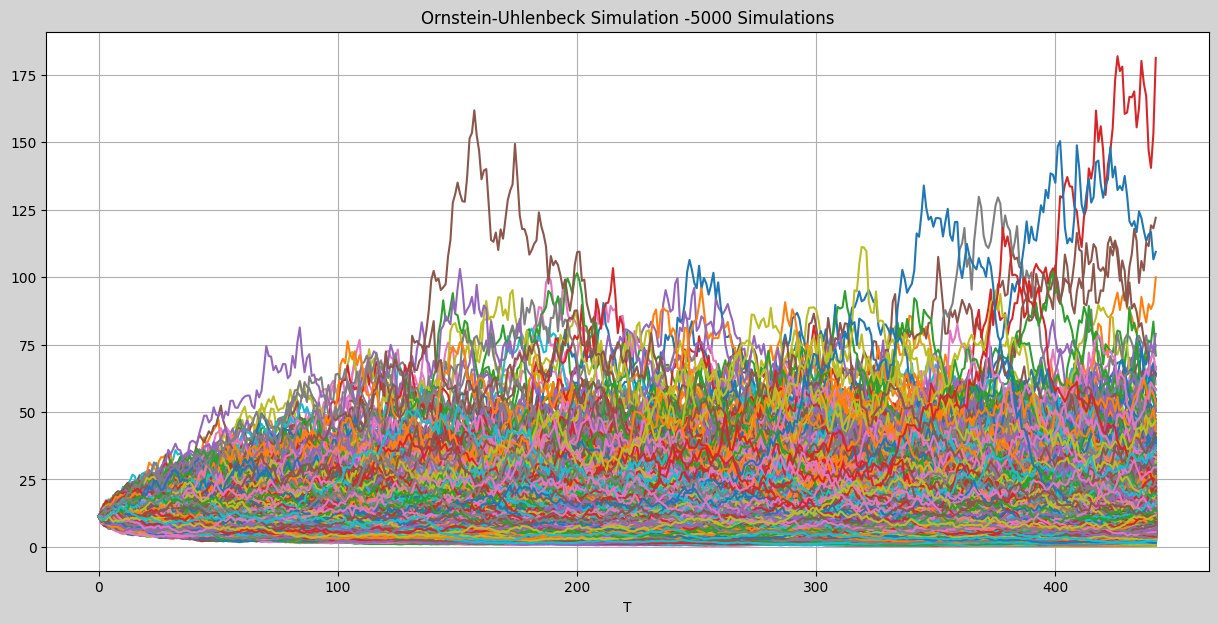

In [723]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7),facecolor= 'lightgray')
plt.title(f'Ornstein-Uhlenbeck Simulation -{N} Simulations')

for sim in simulation_results:
    plt.plot(sim)
plt.xlabel('T')
plt.grid()
plt.show()

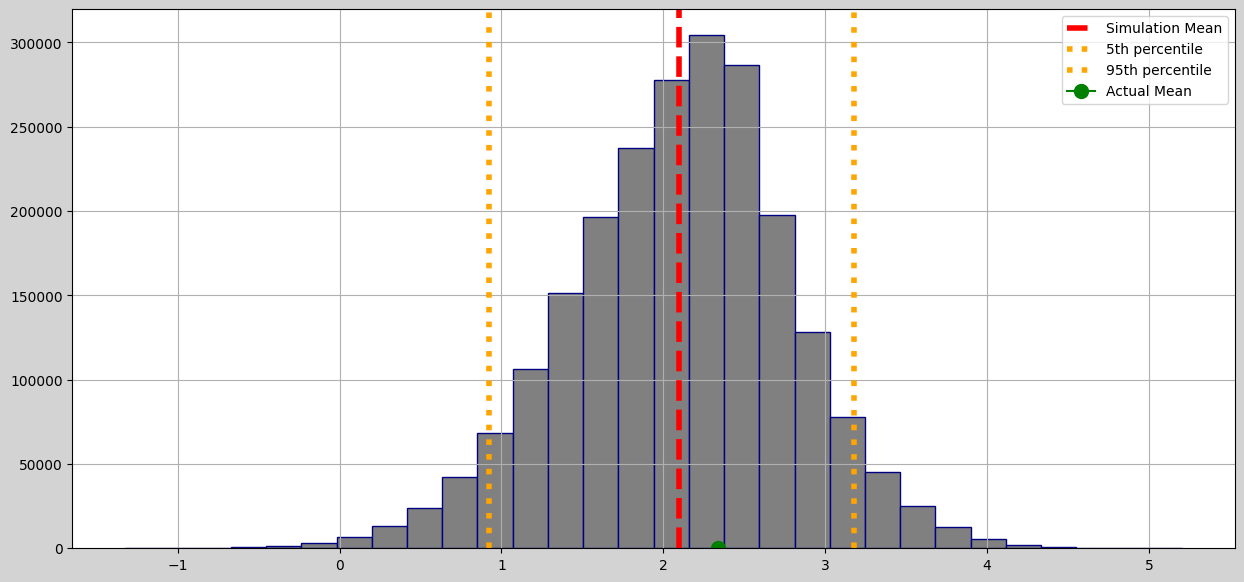

In [724]:
#1)Plot the distribution of simulation results
#2)Check whether the actual mean is contained within the lower (5%) and upper (95%) threshold.
data = np.sort(np.log(simulation_results.flatten()))

simulation_mean = np.mean(data)
actual_mean = np.mean(np.log(price_array))

lower_bound = np.percentile(data,5)
upper_bound = np.percentile(data,95)

plt.figure(figsize=(15,7),facecolor= 'lightgray')
plt.hist(data, edgecolor="navy", color="gray",bins = 30)
plt.axvline(simulation_mean, color='red', linestyle='dashed', linewidth=4, label=f'Simulation Mean')
plt.axvline(lower_bound, color='orange', linestyle='dotted', linewidth=4, label='5th percentile')
plt.axvline(upper_bound, color='orange', linestyle='dotted', linewidth=4, label='95th percentile')

plt.plot(actual_mean,0,marker='o',markersize = 10,color = 'green', label = 'Actual Mean')
plt.legend()
plt.grid()
plt.show()

